## Библиотеки

In [1]:
# работа с файлами (ETL)
import sys
import os
from pathlib import Path

# работа с данными (DQC & ETL)
import numpy as np
# np.set_printoptions(suppress=True)
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pyxlsb
import scipy

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
                            roc_auc_score, confusion_matrix, fbeta_score, confusion_matrix, \
                            classification_report

# pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer
from bayes_opt import BayesianOptimization

# препроцессинг
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

## Чтение предобработанных данных

In [2]:
%%time
# get directory path
dirpath = os.getcwd()
clean_data_path = Path(dirpath) / 'transformed_data'

# load data to dict
data = {}
for file_path in clean_data_path.iterdir():
    if file_path.is_file():
        data[file_path.stem] = pd.read_csv(file_path)
        print(file_path.stem, data[file_path.stem].shape)

Test (37823, 43)
Training (88341, 43)
CPU times: total: 297 ms
Wall time: 301 ms


## Разделение на таргет и признаки

In [3]:
def split_data(data):
    X = data.drop(['MARKER'], axis=1)
    y = data['MARKER']
    print(f'X shape: {X.shape}, y shape: {y.shape}')
    return X, y
X, y = split_data(data['Training'])

X shape: (88341, 42), y shape: (88341,)


In [4]:
X, y = split_data(data['Training'])

X shape: (88341, 42), y shape: (88341,)


## Получение интересующих нас метрик

In [5]:
# to save metrics from models
metrics_data = {}

In [6]:
def get_metrics(y_train_pred, y_val_pred, y_test, y_train, threshold=0.5):

    # классификация
    y_train_01 = y_train_pred >= threshold
    y_val_01 = y_val_pred >= threshold

    # подсчёт метрик
    metrics_df = pd.DataFrame(columns=['Metric', 'Score'])
    metrics_df['Metric'] = [
                            'fbeta',
                            'F1',
                            'Precision',
                            'Recall',
                            'ROC AUC',
                            'Gini'
                           ]
    metrics_df['Score'] = [
                            fbeta_score(y_test, y_val_01, beta=145),
                            f1_score(y_test, y_val_01),
                            precision_score(y_test, y_val_01),
                            recall_score(y_test, y_val_01),
                            roc_auc_score(y_test, y_val_01),
                            2*roc_auc_score(y_test, y_val_01)-1
                          ]

    # матрицы
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.heatmap(confusion_matrix(y_train, y_train_01), annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax=ax1)
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix for train data')
    
    sns.heatmap(confusion_matrix(y_test, y_val_01), annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax=ax2)
    ax2.set_xlabel('Predicted labels')
    ax2.set_ylabel('True labels')
    ax2.set_title('Confusion Matrix for test data')
    
    plt.subplots_adjust(wspace=0.5)
    plt.show()
        
    return metrics_df

def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  #plt.xlim([-0.5,20])
  #plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')      

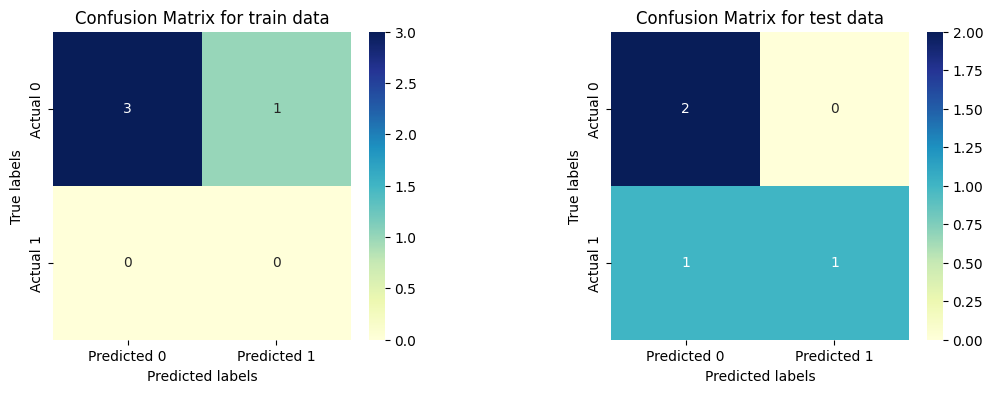

,Metric,Score
0,fbeta,0.500012
1,F1,0.666667
2,Precision,1.000000
3,Recall,0.500000
4,ROC AUC,0.750000
5,Gini,0.500000


In [7]:
get_metrics(np.array([1, 0.5, 0, 0.5]), np.array([0, 0.5, 0.5, 1]), np.array([1, 0, 0, 1]), np.array([0, 0, 0, 0]), threshold=0.7)

## Логистическая регрессия

In [8]:
from sklearn.linear_model import LogisticRegression

Логистическая регрессия один из самых распространнёных алгоритмов в задачах крединтного скоринга. Его основными преимуществами является лёгкость и быстрота обучения, а также простая интерпретируемость. 

Помимо предобработки признаков, моменты, которые следует учесть:
1. Нормализация данных
2. Балансировка классов (будет решаться за счёт установки весов для каждого класса в соответсвии количеству записей)
3. Мультиколлинеарность (будет решаться за счёт регуляризации)
4. Оптимизация гиперпараметров

In [9]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

In [10]:
# to save best params from models
params_data = {}

### Оптимизация гиперпараметров

In [11]:
def lr_cv(C, max_iter):
    #f1_scorer = make_scorer(f1_score, average='weighted')
    recall_scorer = make_scorer(recall_score)
    # precision_scorer = make_scorer(precision_score)
    scaler = StandardScaler()
    model = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', C=C, max_iter=int(max_iter)))
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    val_score = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer).mean()
    return val_score.mean()

### Реализация модели

In [12]:
def log_reg(X, y, scaler = StandardScaler(), seed=42, opt_iter=15):
    # оптимизация
    opt = BayesianOptimization(
        f=lr_cv,
        pbounds={'C': (0.01, 10), 
         'max_iter': (50, 1000)},
        verbose=1,
        random_state=42,
    )
    opt.maximize(n_iter=opt_iter)
    print(opt.max)

    # сплит
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    
    # нормализация
    X_scaled_train = scaler.fit_transform(X_train)
    X_scaled_test = scaler.fit_transform(X_test)
    
    # обучение 
    model = LogisticRegression(class_weight='balanced', C=opt.max['params']['C'], max_iter=int(opt.max['params']['max_iter']))
    model.fit(X_scaled_train, y_train)
    
    # предикт
    y_train_pred = model.predict_proba(X_scaled_train)[:, 1]
    y_val_pred = model.predict_proba(X_scaled_test)[:, 1]

    return y_train_pred, y_val_pred, y_test, opt.max['params']

In [13]:
%%time
y_train_pred, y_val_pred, y_test, params_data['log_reg'] = log_reg(X, y, opt_iter=50)

|   iter    |  target   |     C     | max_iter  |
-------------------------------------------------
{'target': 0.8134581105169341, 'params': {'C': 3.7516557872851513, 'max_iter': 953.1785910894204}}
CPU times: total: 6min 8s
Wall time: 2min 15s


<Axes: ylabel='Count'>

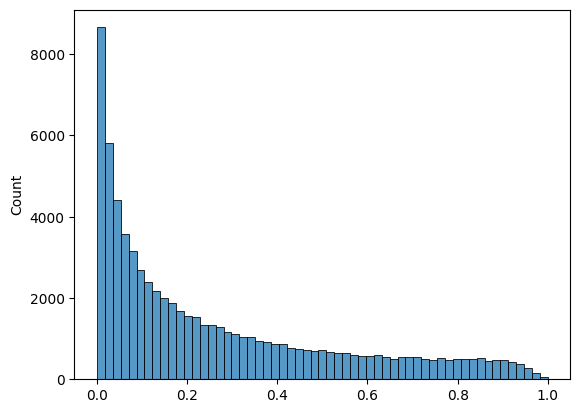

In [14]:
sns.histplot(y_train_pred)

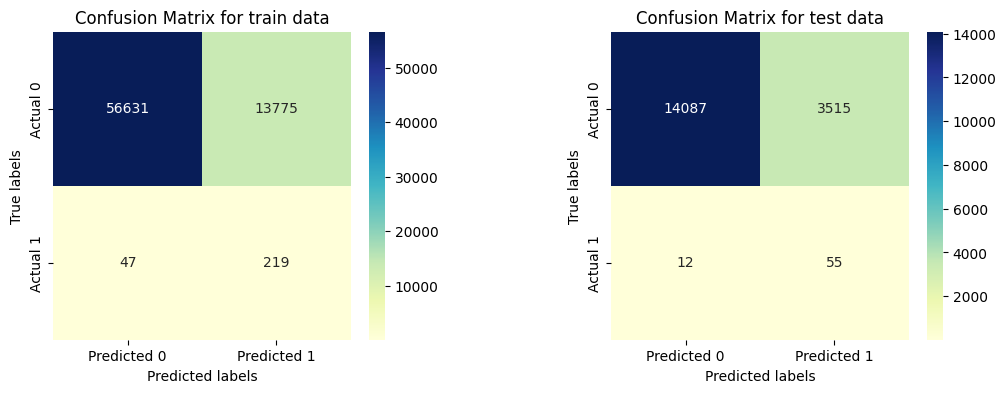

In [15]:
# save metrics
metrics_data['logistic_regression'] = get_metrics(y_train_pred, y_val_pred, y_test, y_train, threshold=0.5)

In [16]:
metrics_data['logistic_regression']

,Metric,Score
0,fbeta,0.818859
1,F1,0.030245
2,Precision,0.015406
3,Recall,0.820896
4,ROC AUC,0.810601
5,Gini,0.621202


## Бустинг

Бустинг считается одним из лучших алгоритмов для работы с табличными данными. Также бустинг за счёт постоянной коррекции ошибки и настраиваемых весов классов, позволит найти хорошее разделение по таргету для несбалансированных данных.

In [17]:
from catboost import CatBoostClassifier

In [18]:
def cb_cv(iterations, learning_rate, depth, l2_leaf_reg):
    recall_scorer = make_scorer(recall_score)
    model = CatBoostClassifier(iterations=int(iterations),
                               learning_rate=learning_rate,
                               depth=int(depth),
                               l2_leaf_reg=l2_leaf_reg,
                               auto_class_weights='Balanced',
                               verbose=False)
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    val_score = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer).mean()
    return val_score.mean()

pbounds = {
           'iterations': (300, 1000),
           'learning_rate': (0.00001, 0.005),
           'depth': (3, 10),
           'l2_leaf_reg': (0, 10)
}
optimizer = BayesianOptimization(f=cb_cv, pbounds=pbounds, random_state=42, verbose=1)
optimizer.maximize(init_points=5, n_iter=30)

|   iter    |  target   |   depth   | iterat... | l2_lea... | learni... |
-------------------------------------------------------------------------
| 2         | 0.7986    | 4.092     | 409.2     | 0.5808    | 0.004332  |
| 8         | 0.8014    | 3.921     | 408.1     | 2.887     | 0.005     |
| 10        | 0.8045    | 3.0       | 407.1     | 1.129     | 0.005     |
| 17        | 0.8074    | 3.0       | 400.5     | 7.919     | 0.005     |
| 21        | 0.8105    | 3.0       | 399.2     | 5.644     | 0.005     |


In [19]:
cb_model = CatBoostClassifier(
                           auto_class_weights='Balanced',
                           iterations=int(optimizer.max['params']['iterations']),
                           depth=int(optimizer.max['params']['depth']),
                           l2_leaf_reg=optimizer.max['params']['l2_leaf_reg'],
                           learning_rate=optimizer.max['params']['learning_rate'],
                           verbose=False
                          )

cb_model.fit(X_train, y_train, eval_set=(X_validation, y_validation), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [20]:
y_train_pred = cb_model.predict_proba(X_train)[:, 1]
y_val_pred = cb_model.predict_proba(X_validation)[:, 1]
params_data['catboost'] = optimizer.max['params']

<Axes: ylabel='Count'>

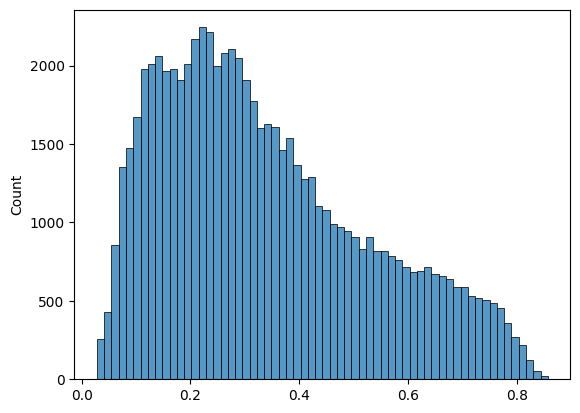

In [21]:
sns.histplot(y_train_pred)

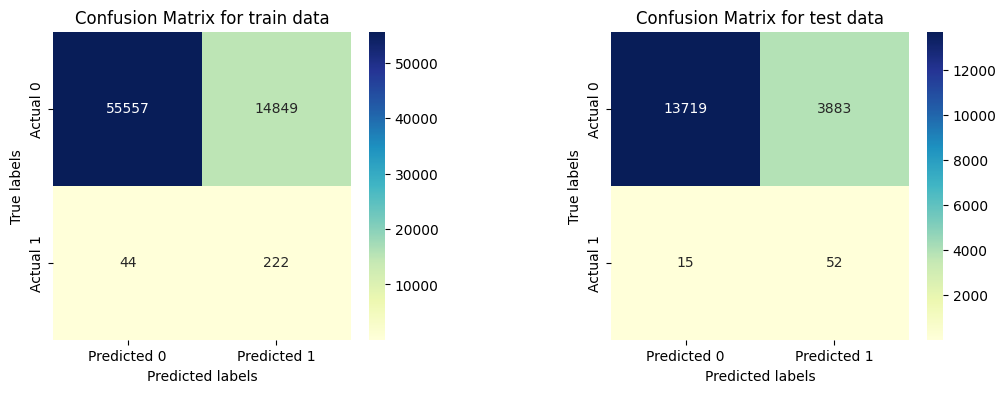

In [22]:
metrics_data['catboost'] = get_metrics(y_train_pred, y_val_pred, y_test, y_train, threshold=0.5)

In [23]:
metrics_data['catboost']

,Metric,Score
0,fbeta,0.773994
1,F1,0.025987
2,Precision,0.013215
3,Recall,0.776119
4,ROC AUC,0.777760
5,Gini,0.555519


In [24]:
y_train_pred = cb_model.predict(X_train)
y_val_pred = cb_model.predict(X_validation)

# Оценка качества модели
print(classification_report(y_validation, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88     17602
           1       0.01      0.78      0.03        67

    accuracy                           0.78     17669
   macro avg       0.51      0.78      0.45     17669
weighted avg       1.00      0.78      0.87     17669



## Нейронная сеть

Так как данные зашифрованны, то возможности в проведении EDA частично ограничены, в связи с чем неплохим решением будет обучение нейросети, которая потенциально может выявить какие-то неочевидные паттерны в данных.

### Подготовка

In [25]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [26]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)

In [28]:
neg, pos = np.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 88341
    Positive: 333 (0.38% of total)



In [29]:
weight_for_0 = (1 / y_train.where(y_train == 0).count()) * (y_train.count() / 2.0)
weight_for_1 = (1 / y_train.sum()) * (y_train.count() / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 132.84


In [30]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # model's loss
      keras.metrics.F1Score(name='F1'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [31]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          24, activation='relu',
          input_shape=(X_train.shape[-1],)),
      keras.layers.Dense(
          12, activation='relu',
          input_shape=(12, )),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Предобучение для подбора весов инициализации

In [32]:
EPOCHS = 300
BATCH_SIZE = 1024

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [33]:
model = make_model()
model.summary()

C:\Users\yarmolyuk_ms\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 24)                  │           1,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.predict(X_train[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


array([[0.41372275],
       [0.39856273],
       [0.44154388],
       [0.34569052],
       [0.41696694],
       [0.65232825],
       [0.50844157],
       [0.36528102],
       [0.58010286],
       [0.42089498]], dtype=float32)

In [35]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6841


In [36]:
initial_bias = np.log([pos/neg])
initial_bias

array([-5.57704051])

In [37]:
model = make_model(output_bias=initial_bias)
model.predict(X_train[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([[0.00088848],
       [0.00359551],
       [0.00628112],
       [0.00453326],
       [0.00225842],
       [0.00129785],
       [0.0011477 ],
       [0.00386703],
       [0.00435249],
       [0.00365585]], dtype=float32)

In [38]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0255


In [39]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights.weights.h5')
model.save_weights(initial_weights)

In [40]:
model = make_model()
model.load_weights(initial_weights)
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_validation, y_validation), 
    verbose=0)

In [41]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_validation, y_validation), 
    verbose=0)

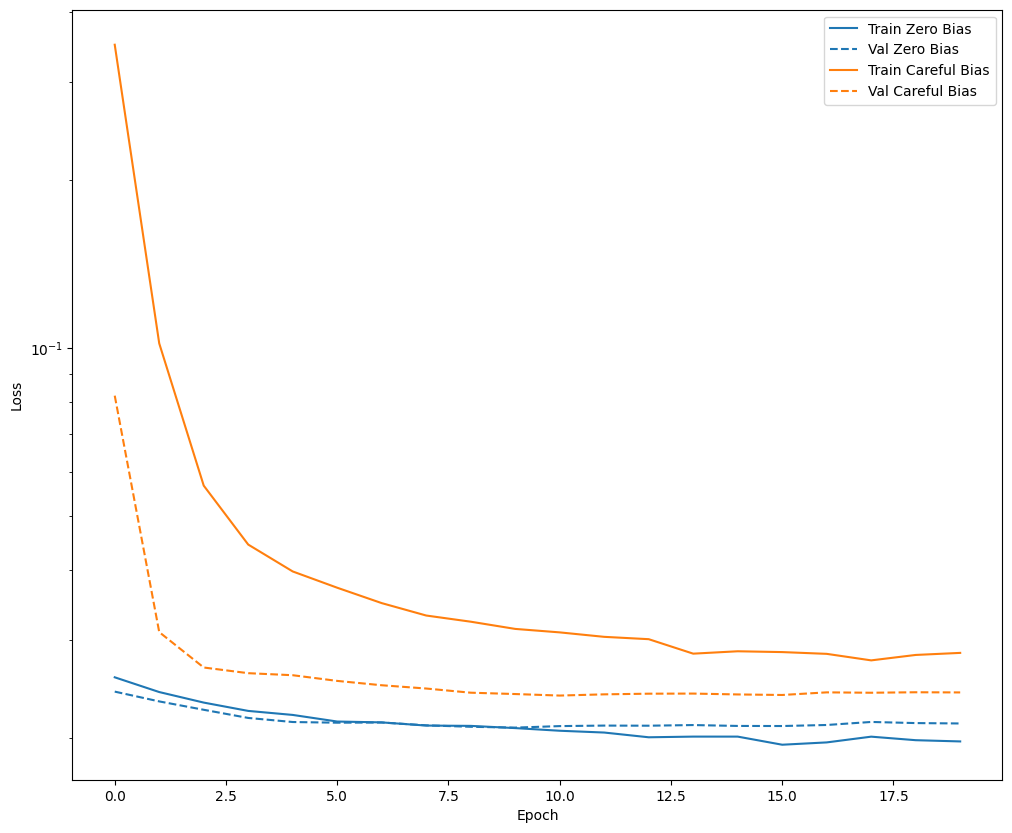

In [42]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

## Обучение моделей

### Взвешенная модель

In [43]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [44]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train.reset_index(drop=True),
    batch_size=BATCH_SIZE,
    epochs=60,
    callbacks=[early_stopping],
    validation_data=(X_validation, y_validation),
    class_weight=class_weight,
    verbose=0
)

C:\Users\yarmolyuk_ms\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_f1` which is not available. Available metrics are: F1,auc,cross entropy,loss,prc,precision,recall,val_F1,val_auc,val_cross entropy,val_loss,val_prc,val_precision,val_recall
  current = self.get_monitor_value(logs)


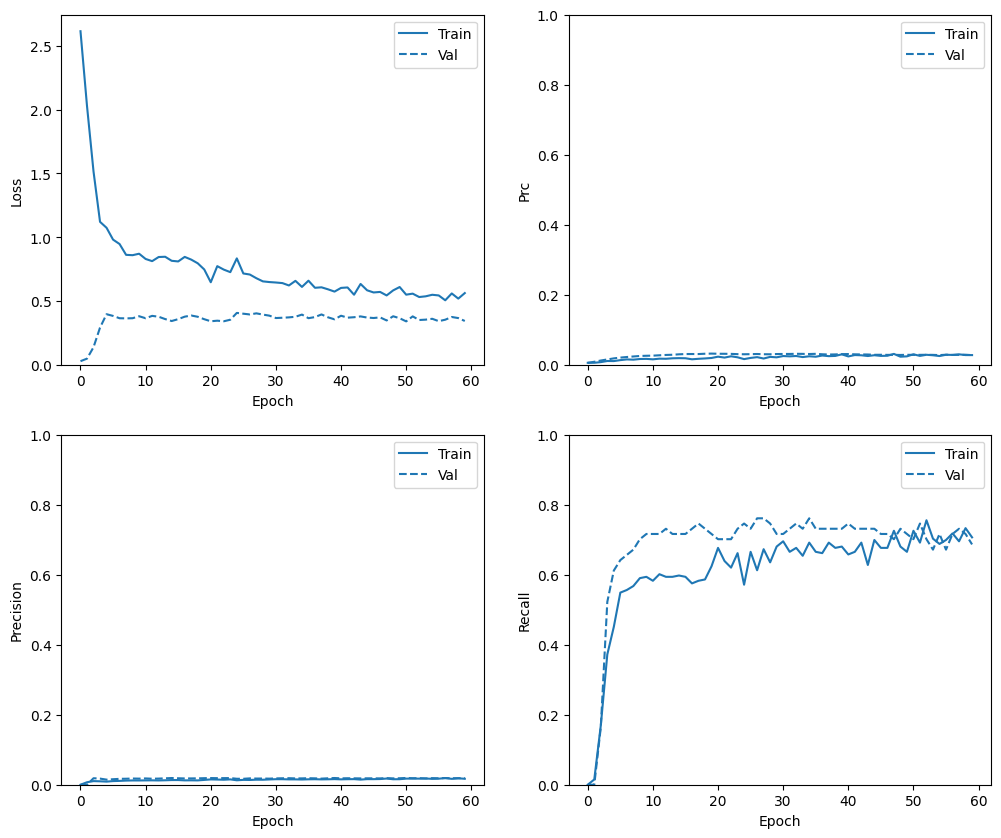

In [45]:
plot_metrics(weighted_history)

In [46]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
validation_predictions_weighted = weighted_model.predict(X_validation, batch_size=BATCH_SIZE)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


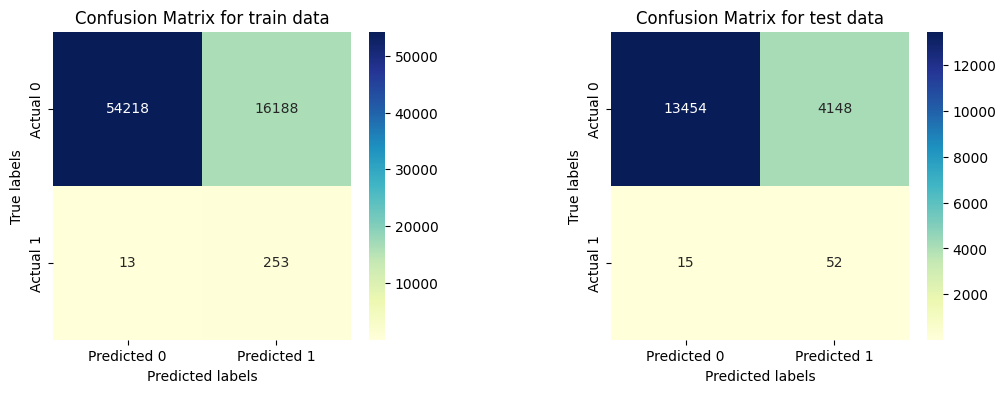

In [47]:
metrics_data['neural_network_weighted'] = get_metrics(train_predictions_weighted, validation_predictions_weighted, y_validation, y_train, threshold=0.25)

In [48]:
metrics_data['neural_network_weighted']

,Metric,Score
0,fbeta,0.773849
1,F1,0.024373
2,Precision,0.012381
3,Recall,0.776119
4,ROC AUC,0.770232
5,Gini,0.540464


### Модель на дублирующемся минорном классе

#### Подготовка

In [49]:
train_df, val_df = train_test_split(data['Training'], test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('MARKER'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('MARKER'))

train_features = np.array(train_df)
val_features = np.array(val_df)

In [50]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [51]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

print(f'res_pos_features shape: {res_pos_features.shape}')

res_pos_features shape: (70398, 42)


In [52]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

print(f'resampled_features shape: {resampled_features.shape}')

resampled_features shape: (140796, 42)


In [53]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [54]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [1.53100000e-01 1.53100000e-01 1.57490000e+02 3.67510000e+02
 4.59387500e-01 4.59387500e-01 3.00000000e+00 0.00000000e+00
 3.73333333e+01 6.00000000e+01 1.00000000e+00 0.00000000e+00
 2.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]

Label:  1


In [55]:
BATCH_SIZE = 2048

pos_ds = pos_ds.map(lambda x, y: (x, tf.expand_dims(y, axis=-1)))
neg_ds = neg_ds.map(lambda x, y: (x, tf.expand_dims(y, axis=-1)))

resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [56]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.5126953125


In [57]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)

In [58]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels.reshape(-1, 1))).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

C:\Users\yarmolyuk_ms\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch=20,
    epochs=15,
    callbacks=[early_stopping],
    validation_data=(val_ds),
    verbose=1
)

Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - F1: 0.3491 - auc: 0.6633 - cross entropy: 20.0059 - loss: 40.3355 - prc: 0.4218 - precision: 0.3995 - recall: 0.7300 - val_F1: 0.0067 - val_auc: 0.3900 - val_cross entropy: 15.0214 - val_loss: 15.0214 - val_prc: 0.0026 - val_precision: 0.0034 - val_recall: 0.9661
Epoch 2/15
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - F1: 0.5709 - auc: 0.4715 - cross entropy: 21.1332 - loss: 21.1332 - prc: 0.4862 - precision: 0.4771 - recall: 0.5478

C:\Users\yarmolyuk_ms\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_f1` which is not available. Available metrics are: F1,auc,cross entropy,loss,prc,precision,recall,val_F1,val_auc,val_cross entropy,val_loss,val_prc,val_precision,val_recall
  current = self.get_monitor_value(logs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - F1: 0.5766 - auc: 0.4770 - cross entropy: 19.8138 - loss: 19.8138 - prc: 0.4895 - precision: 0.4819 - recall: 0.5472 - val_F1: 0.0072 - val_auc: 0.4850 - val_cross entropy: 1.9280 - val_loss: 1.9280 - val_prc: 0.0030 - val_precision: 0.0027 - val_recall: 0.3898
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - F1: 0.6422 - auc: 0.5476 - cross entropy: 7.4185 - loss: 7.4185 - prc: 0.5339 - precision: 0.5402 - recall: 0.4898 - val_F1: 0.0074 - val_auc: 0.6696 - val_cross entropy: 1.6817 - val_loss: 1.6817 - val_prc: 0.0056 - val_precision: 0.0049 - val_recall: 0.5424
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - F1: 0.6844 - auc: 0.6205 - cross entropy: 2.5998 - loss: 2.5998 - prc: 0.5950 - precision: 0.5902 - recall: 0.5203 - val_F1: 0.0072 - val_auc: 0.6577 - val_cross entropy: 0.8620 - val_loss: 0.8620 - val_prc: 0.0061 - val_precision: 0.0050 - val_recall: 0.6441
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - F1: 0.6845 - auc:

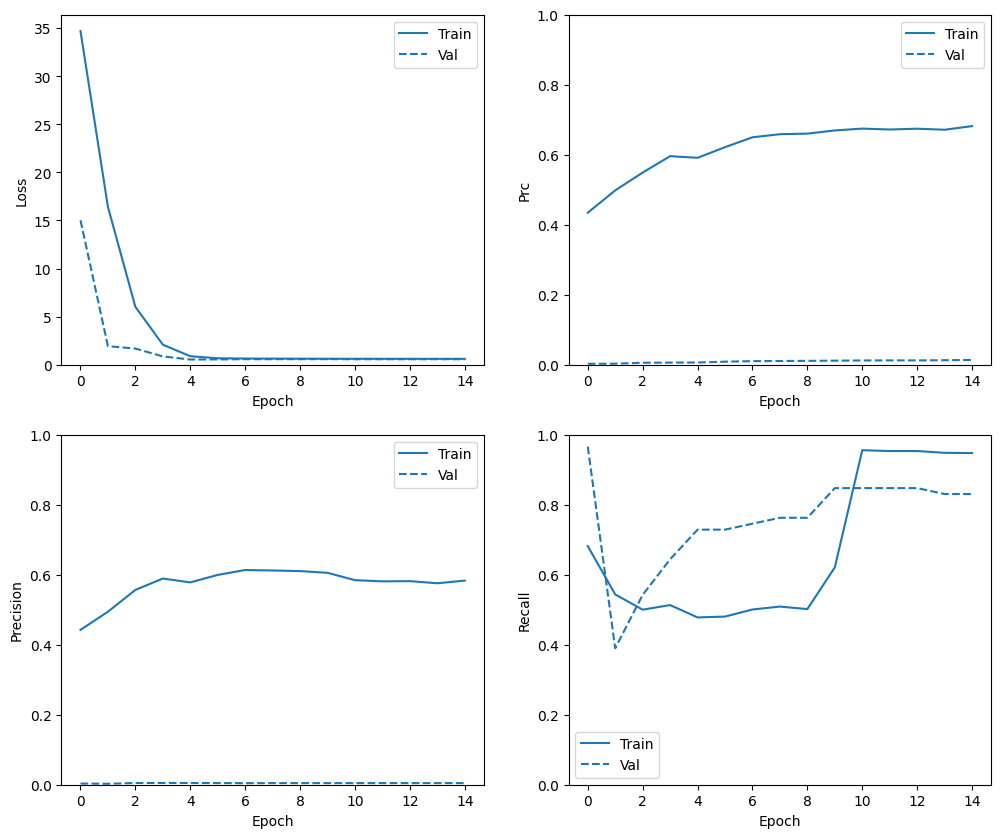

In [60]:
plot_metrics(resampled_history)

In [61]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
validation_predictions_resampled = resampled_model.predict(val_features, batch_size=BATCH_SIZE)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


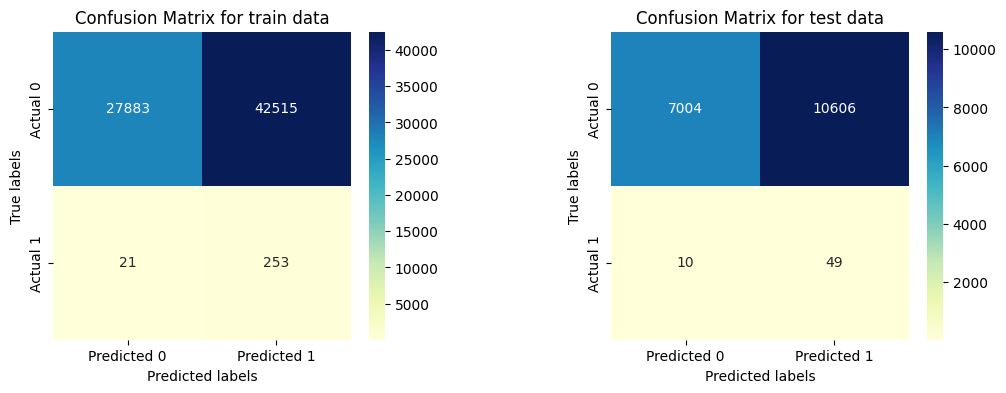

In [62]:
metrics_data['neural_network_oversampling_by_copy1class'] = get_metrics(train_predictions_resampled, validation_predictions_resampled, val_labels, train_labels, threshold=0.5)

In [63]:
metrics_data['neural_network_oversampling_by_copy1class']

,Metric,Score
0,fbeta,0.823475
1,F1,0.009147
2,Precision,0.004599
3,Recall,0.830508
4,ROC AUC,0.614119
5,Gini,0.228237


<Axes: ylabel='Count'>

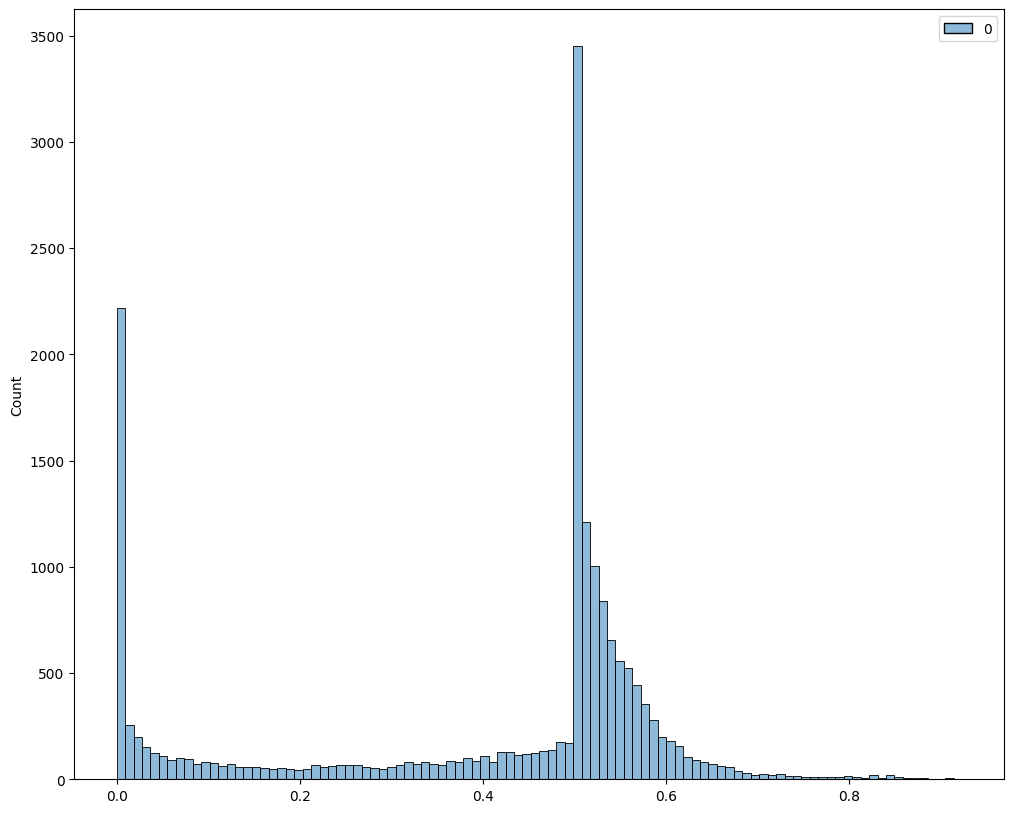

In [64]:
sns.histplot(validation_predictions_resampled, bins=100, kde=False)

## Сравнение моделей

C:\Users\yarmolyuk_ms\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


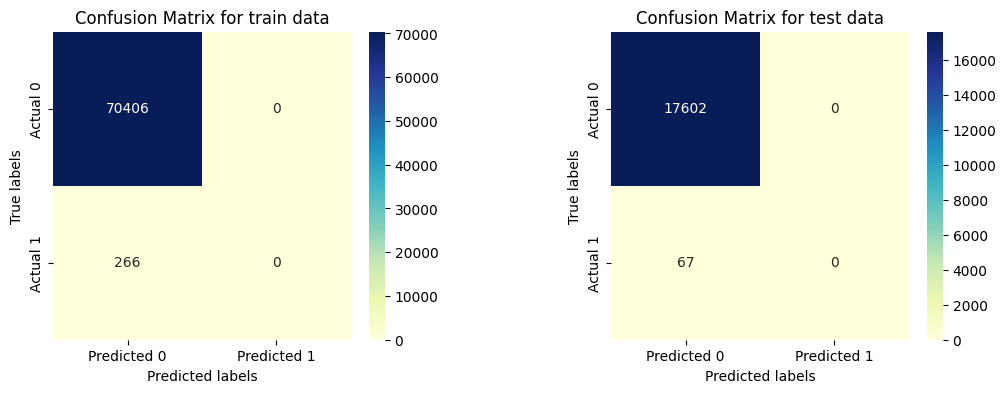

In [65]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(X_train, y_train)

y_train_pred_dummy = dummy_clf.predict(X_train)
y_validation_pred_dummy = dummy_clf.predict(X_validation)

metrics_data['dummy_classifier'] = get_metrics(y_train_pred_dummy, y_validation_pred_dummy, y_validation, y_train)

In [66]:
df = pd.concat(metrics_data.values(), keys=metrics_data.keys()).reset_index().pivot(index='level_1', columns='level_0', values='Score')

metrics = [metric for metric, _ in metrics_data['logistic_regression'].to_numpy()]
df.columns = [data_name.capitalize() for data_name in df.columns]
df.index = metrics

In [67]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

styled_df = df.style.apply(highlight_max, subset=df.columns, axis=1)
styled_df

,Catboost,Dummy_classifier,Logistic_regression,Neural_network_oversampling_by_copy1class,Neural_network_weighted
fbeta,0.773994,0.000000,0.818859,0.823475,0.773849
F1,0.025987,0.000000,0.030245,0.009147,0.024373
Precision,0.013215,0.000000,0.015406,0.004599,0.012381
Recall,0.776119,0.000000,0.820896,0.830508,0.776119
ROC AUC,0.777760,0.500000,0.810601,0.614119,0.770232
Gini,0.555519,0.000000,0.621202,0.228237,0.540464


* Если у dummy_classifiera метрика лучше или незначительно отличается по сравнению с остальными моделями - значит это метрика не подохдит для нашей задачи.
* Как видими по метрикам лучше всего с классификацией справляется логистическая регрессия. В таких задача с классификацией несбалансированных классов 
 высокий Recall чаще всего приоритетнее, так как вероятность ошибки по 1 классу дороже.

## Применение лучшей модели на тестовую выборку

In [68]:
X_test, y_test = data['Test'].drop(['MARKER'], axis=1), data['Test']['MARKER']

In [69]:
params_data['log_reg']

{'C': 3.7516557872851513, 'max_iter': 953.1785910894204}

In [70]:
scaler = StandardScaler()
model_log_reg = make_pipeline(StandardScaler(),  LogisticRegression(class_weight='balanced',
                                                            C=params_data['log_reg']['C']-1,
                                                            max_iter=int(params_data['log_reg']['max_iter']+1000
                                                                        )
                                                           )
                     )


In [71]:
model_log_reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=2.7516557872851513,
                                    class_weight='balanced', max_iter=1953))])

In [72]:
X.shape

(88341, 42)

In [73]:
y_train_pred = model_log_reg.predict_proba(X)[:, 1]
y_test_pred = model_log_reg.predict_proba(X_test)[:, 1]

C:\Users\yarmolyuk_ms\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\yarmolyuk_ms\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


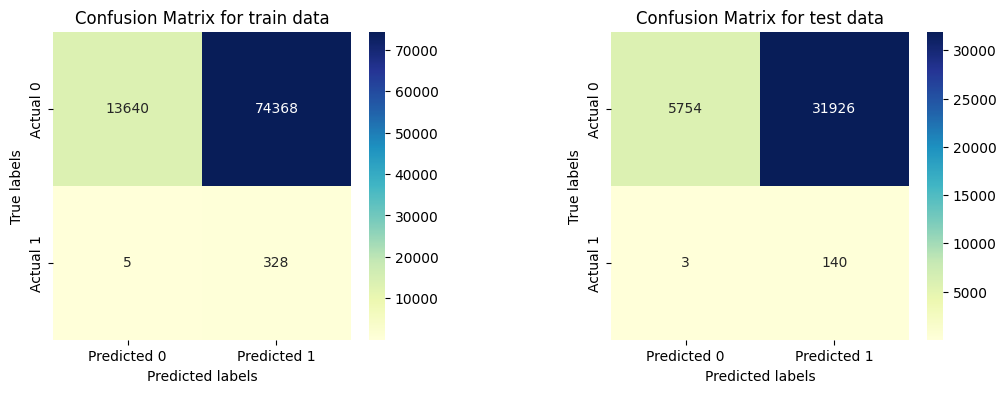

,Metric,Score
0,fbeta,0.968736
1,F1,0.008693
2,Precision,0.004366
3,Recall,0.979021
4,ROC AUC,0.565864
5,Gini,0.131728


In [74]:
get_metrics(y_train_pred, y_test_pred, y_test, y, threshold=0.5)

Логистическая регрессия дала смещённые результаты

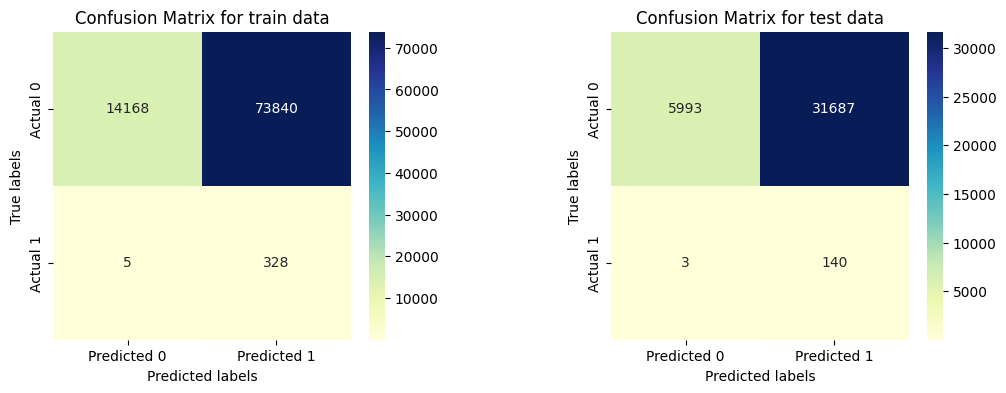

,Metric,Score
0,fbeta,0.968812
1,F1,0.008758
2,Precision,0.004399
3,Recall,0.979021
4,ROC AUC,0.569035
5,Gini,0.138071


In [75]:
get_metrics(y_train_pred, y_test_pred, y_test, y, threshold=0.99)

При взятии порога результаты оказались лучше, но это не совсем то, что нам нужно - модель не выучила генерализируемость данных.
Так как результаты логистической регрессии не удовлетворительные с моей точки зрения, попробую посмотреть как поведут себя остальные модели на тестовых данных.

In [76]:
cb_model = CatBoostClassifier(
                           auto_class_weights='Balanced',
                           iterations=int(optimizer.max['params']['iterations']),
                           depth=int(optimizer.max['params']['depth']),
                           l2_leaf_reg=optimizer.max['params']['l2_leaf_reg'],
                           learning_rate=optimizer.max['params']['learning_rate'],
                           verbose=False
                          )

cb_model.fit(X, y)

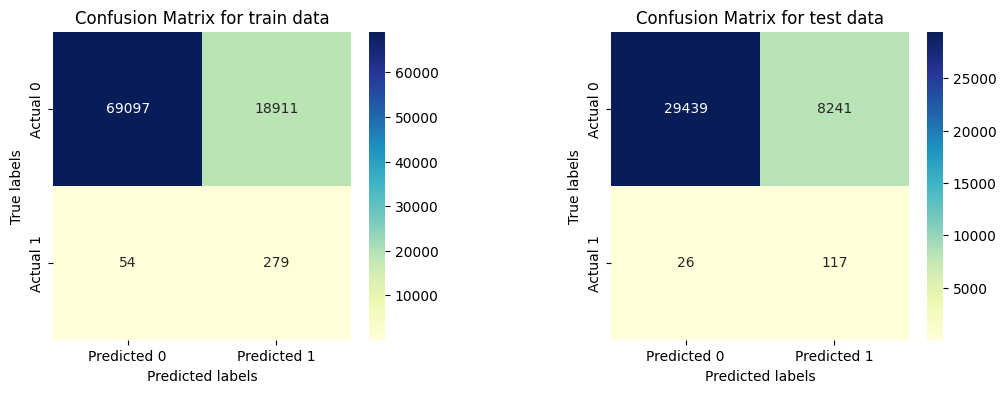

,Metric,Score
0,fbeta,0.815952
1,F1,0.027526
2,Precision,0.013999
3,Recall,0.818182
4,ROC AUC,0.799736
5,Gini,0.599472


In [77]:
y_train_pred = cb_model.predict_proba(X)[:, 1]
y_test_pred = cb_model.predict_proba(X_test)[:, 1]
get_metrics(y_train_pred, y_test_pred, y_test, y, threshold=0.5)

А вот бустинг показывает довольно хорошую генерализируемость и неплохие метрики.

In [78]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X,
    y.reset_index(drop=True),
    batch_size=BATCH_SIZE,
    epochs=50,
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=0
)

C:\Users\yarmolyuk_ms\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\yarmolyuk_ms\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_f1` which is not available. Available metrics are: F1,auc,cross entropy,loss,prc,precision,recall
  current = self.get_monitor_value(logs)


In [79]:
train_predictions_weighted = weighted_model.predict(X, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


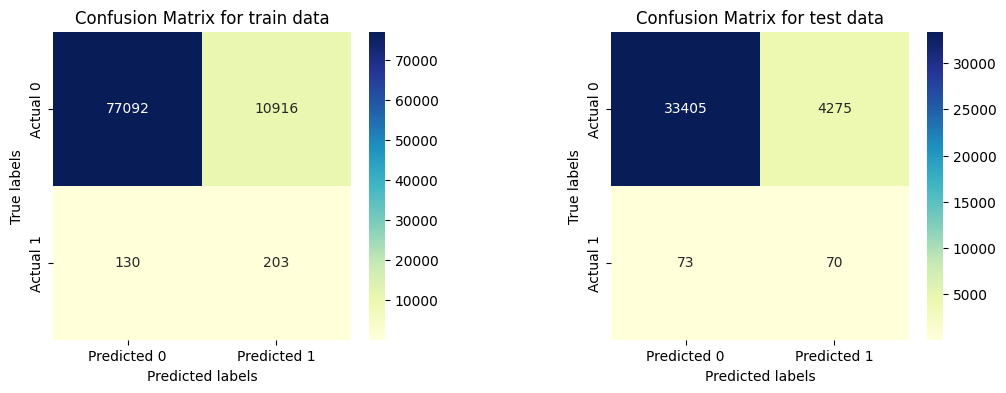

,Metric,Score
0,fbeta,0.488827
1,F1,0.031194
2,Precision,0.016110
3,Recall,0.489510
4,ROC AUC,0.688028
5,Gini,0.376055


In [80]:
get_metrics(train_predictions_weighted, test_predictions_weighted, y_test, y, threshold=0.25)

Нейросеть также дала хорошую генерализируемость, c примерно одинаковыми метрикам как и у бустинга.

### Как можно было улучшить результат

* Попробовать бустинг, реализованный для работы с несбалансированными классами MEBoost
* Добавить оптимизацию гиперпараметров для сети, а потом обучить с начальными весами, полученными с предобученной нейросети
* Для обучения моделей делать более генерализированные выборки путём кластеризации ( в случаях когда мы обучаемся на малых частях данных, например в случае бустинга или семплирования батчей для нейросети вручную), потому что стратифицированный отбор не гарантирует генералилизируемость выборки
* Сделать жадный перебор всем возможных комбинаций из вариантов решения проблемы дизбаланса классов, мультиколлинеарности и модели, в результате чего выбрать лучшую ( для этого удобнее было переписать всё на классы, например Preprocessing, Validation, Evaluation и т.д.)